# Optimizing Opportunity Charging Locations
This example shows how to use the `ChargerLocationModel` class to solve our charger location model for a particular problem instance and visualize some of the results.

First, we import all dependencies and set up logging of results.

In [14]:
from beb_chargers.scripts.script_helpers import build_trips_df, \
    build_charger_location_inputs
from beb_chargers.opt.charger_location import ChargerLocationModel
from beb_chargers.gtfs_beb import GTFSData
from beb_chargers.vis import plot_trips_and_terminals, plot_deadhead
from pathlib import Path
import datetime
import pandas as pd
import logging
logging.basicConfig(level=logging.INFO)

## Setting up problem parameters
In the following sections, we'll define input data for our problem. We look into selecting charging locations for a set of 21 bus routes in South King County, WA. The candidate charging locations are stored at `beb_chargers/data/so_king_cty_sites.csv` and we assume each charger has a power output of 450 kW. We define the depot location where all buses start and end service to be Metro's South Base. Bus trip and schedule data comes from the Metro GTFS feed and we'll run our test for March 28, 2024.

### Define charger parameters

In [15]:
# Power output of each charger. Note that the model expects a unit of
# kilowatt-hours per minute, so that the amount of energy gained equals
# charging time (in minutes) multiplied by power (in kWh/min). Here, we
# use 450 kW = 450 / 60 kWh/min
chg_pwrs = 450 / 60

# Maximum number of chargers per site. We'll set it to 4 everywhere
n_max = 4

# Cost parameters. See TRC paper for where the values come from.
s_cost = 200000
c_cost = 698447
alpha = 190 * 365 * 12 / 60

# Locate CSV file giving candidate charger sites for this instance
site_fname = Path.cwd().parent / 'beb_chargers' / 'data' / 'site_location' / 'so_king_cty_sites.csv'

# Load candidate charging sites given by Metro and add params as columns
loc_df = pd.read_csv(site_fname)
loc_df['max_chargers'] = n_max
loc_df['kw'] = chg_pwrs * 60
loc_df['fixed_cost'] = s_cost
loc_df['charger_cost'] = c_cost

# Define coordinates of overnight depot at South Base
depot_coords = (47.495809, -122.286190)

### Read in GTFS data

In [16]:
# Directory to GTFS files, as a platform-agnostic path
gtfs_dir = Path.cwd().parent / 'beb_chargers' / 'data' / 'gtfs' / 'metro_mar24'

# Load GTFS data into our custom object
gtfs = GTFSData.from_dir(gtfs_dir)

### Define bus parameters

In [17]:
# Battery capacity in kWh
battery_cap = 300
# Energy consumption per mile for all buses (we'll assume it's the same
# for all buses here)
kwh_per_mi = 3

### Set which routes are included

In [18]:
# All routes included in analysis
beb_routes = [
    101, 102, 105, 106, 107, 131, 132,
    150, 153, 156, 160, 161, 162, 165,
    168, 177, 182, 183, 187, 193, 240
]
beb_routes = [str(r) for r in beb_routes]

## Build DataFrame containing all trips in this instance and their details

In [19]:
# We'll run analysis for March 28, 2024
ocl_date = datetime.datetime(2024, 3, 28)
osm = Path.cwd().parent / 'beb_chargers' / 'data' / 'osm' / 'osm_charge_data.pickle'
# Call helper function to build up DF
beb_trips = build_trips_df(
    gtfs=gtfs,
    date=ocl_date,
    routes=beb_routes,
    depot_coords=depot_coords,
    add_depot_dh=True,
    add_kwh_per_mi=False,
    add_durations=False,
    routes_60=[],
    osm_fname = osm
)
# Add a column giving energy consumption for each trip
beb_trips['kwh_per_mi'] = kwh_per_mi

In [20]:
# Record how many trips and blocks are active on our specified routes on this day
logging.info(
    '{}: There are {} total trips to be served by {} BEB blocks.'.format(
        ocl_date.strftime('%m/%d/%y'), len(beb_trips), beb_trips['block_id'].nunique()
    )
)

INFO:root:03/28/24: There are 1285 total trips to be served by 174 BEB blocks.


## Show a map of the trips and chargers included in this instance
The helper function `plot_trips_and_terminals` from `beb_chargers.vis` will create an overview map of our instance. When we show the map in a Jupyter notebook, it will show up as short and wide, which doesn't look great for Seattle. Running in pure Python, it'll pop up in a browser tab that you can easily resize to get a nicer shape. Likewise, you could save it as .html to view in the browser. See the `plotly` documentation for details.

In [21]:
# Create a map of the problem instance
inst_map = plot_trips_and_terminals(
    beb_trips, loc_df, gtfs.shapes_df, 'light'
)
# These config params make map downloads higher resolution
config = {
    'toImageButtonOptions': {
        'format': 'png',
        'scale': 3
    }
}
inst_map.show(config=config)

## Package together inputs for charger location
`build_charger_location_inputs` provides a convenient wrapper for collecting all the inputs to create a `ChargerLocationModel`. We need to provide our DataFrame of trip info, our `GTFSData` instance, the DataFrame of candidate charging sites, depot location, and battery capacity of buses (while the model can handle a different capacity for each bus, this function assumes they're all the same when building up inputs, which is usually how it works when I'm testing).

The return value of this function is a dictionary of keyword arguments `opt_kwargs` containing all of the inputs necessary to instantiate and then run a `ChargerLocationModel`.

In [22]:
opt_kwargs = build_charger_location_inputs(
    gtfs=gtfs,
    trips_df=beb_trips,
    chargers_df=loc_df,
    depot_coords=depot_coords,
    battery_cap=battery_cap,
    osm_fname = osm,
)

## Build and run the optimization model

In [23]:
# Create instance of charger location model based on those inputs
clm = ChargerLocationModel(**opt_kwargs)
# Solve the model with zero optimality gap
clm.solve(alpha=alpha, opt_gap=0, bu_kwh=battery_cap, jupyter_case=osm)

INFO:charger_location:Number of blocks that require charging: 121
INFO:charger_location:Number of trips in charging blocks: 1383
INFO:charger_location:Number of infeasible blocks: 9
INFO:charger_location:Infeasible block IDs: ['7157281', '7157609', '7157753', '7157761', '7157763', '7157768', '7157769', '7157781', '7157826']
INFO:charger_location:Number of trips in infeasible blocks: 49
INFO:charger_location:Time for heuristic runs: 0.24 seconds
INFO:charger_location:Average number of backups: 11.58
INFO:charger_location:Minimum number of backups: 10

INFO:charger_location:Mean Conflict set size: 4.78
INFO:gurobipy:Read LP format model from file C:\Users\stlp\AppData\Local\Temp\tmp535gekxj.pyomo.lp
INFO:gurobipy:Reading time = 0.04 seconds
INFO:gurobipy:x1: 6865 rows, 3650 columns, 15662 nonzeros
INFO:gurobipy:Set parameter MIPGap to value 0
INFO:gurobipy:Set parameter MIPFocus to value 3
INFO:gurobipy:Set parameter Method to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v

### Understanding the output
The `logging` module is used to provide some info as the solution process evolves. First, the model does some simple math to identify the number of blocks that must use opportunity charging (121 in this case) and the total number of trips on these blocks (1383).

Next, the model reports the number of infeasible blocks that will not be able to complete all trips on timing using the proposed opportunity charging infrastructure, even if the maximum number of chargers is installed everywhere. Here, there are 9 infeasible blocks that serve a total of 49 trips combined. The BEB-BRP model is used to revise these blocks so that they are feasible by serving them with a fleet of additional backup buses. The best solution in this case dispatches 10 backup buses.

After the BRP is solved, charger locations are optimized based on the revised blocks. We log some info about the solution process. First, this includes info about the conflict sets that are populated to create queue prevention constraints. In this case, the mean size of each conflict set is 4.79. Then we get updates on the solution progress as we generate constraints lazily whenever they are violated. The initial model includes no prevention constraints, the next has 169, the next has 172, and then the model is solved to optimality.

Note that it's possible you could get slightly different results from what I wrote above because there may be some randomness in the solver, but the final solution should have the same objective value.

## Log the results

In [24]:
clm.log_results()

INFO:charger_location:Total number of backup buses used: 10
INFO:charger_location:Optimal objective function value: 25124269.40
INFO:charger_location:Optimal stations: ['Burien Transit Center', 'Federal Way Transit Center', 'Kent Des Moines Link Station', 'Kent Transit Center', 'South Renton P&R']
INFO:charger_location:Number of chargers: {'Burien Transit Center': 3, 'Federal Way Transit Center': 2, 'Kent Des Moines Link Station': 1, 'Kent Transit Center': 2, 'South Renton P&R': 4}
INFO:charger_location:Optimal number of charger visits: 273.0
INFO:charger_location:Optimal total charging time: 3919.58 minutes
INFO:charger_location:Average time per charge: 14.36 minutes


Calling `log_results()` gives us summary info about the result of our solve. We get the number of backup buses from BEB-BRP, final objective value of BEB-OCL, charging sites that are used, number of chargers at each location, and information about how chargers are used including the total number of charger visits, total time spent charging, and average charging duration. 

## Create some plots

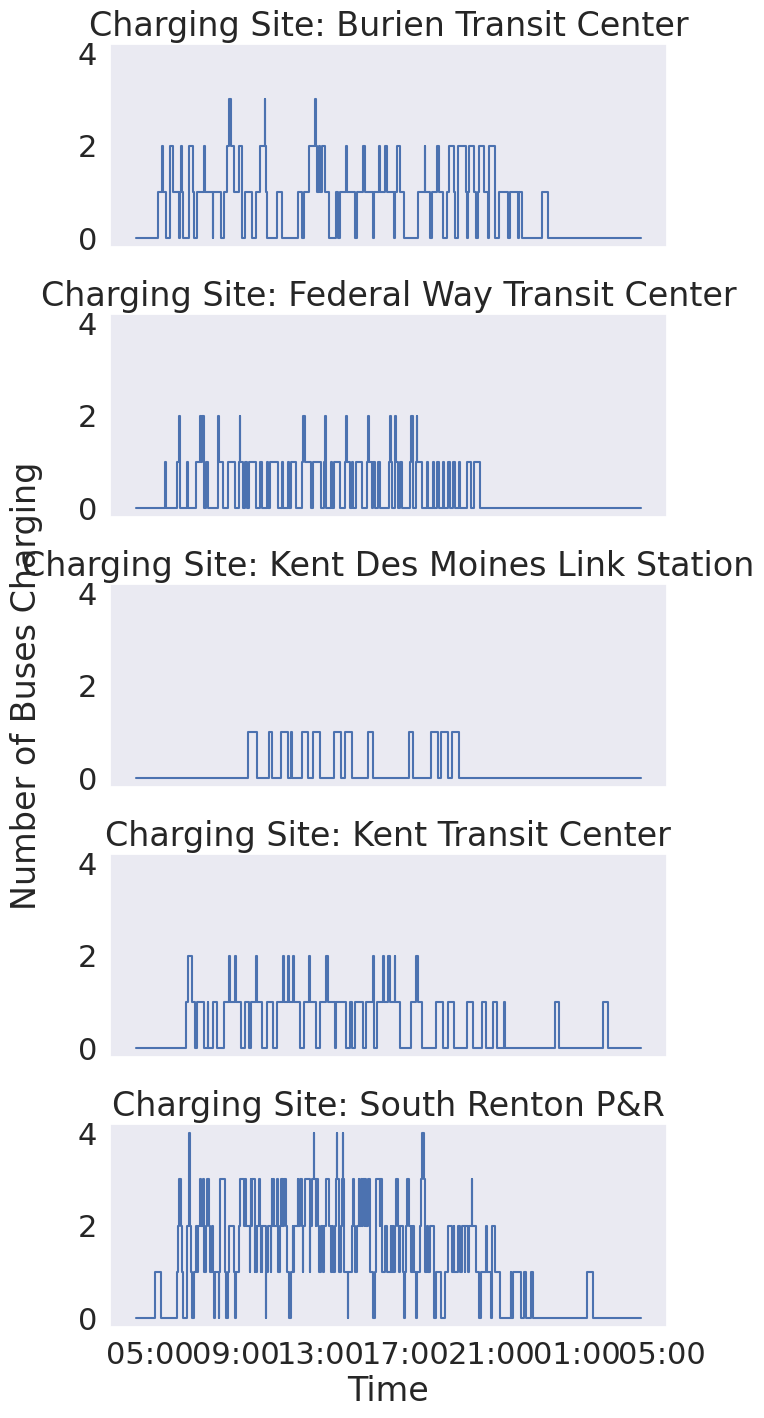

In [25]:
# Plot charger utilization at each site
# This is a static plot made with Matplotlib
clm.plot_chargers()

In [26]:
# Create map of deadhead driving to/from chargers
# Ignore the log messages below, which come from the Google Maps directions API
# that determines the driving paths shown
fig = plot_deadhead(
    result_df=clm.to_df(), loc_df=loc_df, coords_df=beb_trips
)
fig.show()

INFO:googlemaps.client:API queries_quota: 60
INFO:googlemaps.client:API queries_quota: 60
INFO:googlemaps.client:API queries_quota: 60
INFO:googlemaps.client:API queries_quota: 60
INFO:googlemaps.client:API queries_quota: 60
INFO:googlemaps.client:API queries_quota: 60
INFO:googlemaps.client:API queries_quota: 60
INFO:googlemaps.client:API queries_quota: 60
INFO:googlemaps.client:API queries_quota: 60
INFO:googlemaps.client:API queries_quota: 60
INFO:googlemaps.client:API queries_quota: 60
INFO:googlemaps.client:API queries_quota: 60
INFO:googlemaps.client:API queries_quota: 60
INFO:googlemaps.client:API queries_quota: 60
INFO:googlemaps.client:API queries_quota: 60
INFO:googlemaps.client:API queries_quota: 60
INFO:googlemaps.client:API queries_quota: 60
